In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.widgets import *
from PIL import Image

     |████████████████████████████████| 720 kB 4.1 MB/s 
     |████████████████████████████████| 48 kB 4.9 MB/s 
     |████████████████████████████████| 1.2 MB 31.3 MB/s 
     |████████████████████████████████| 189 kB 51.6 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 51 kB 310 kB/s 
     |████████████████████████████████| 558 kB 36.1 MB/s 
     |████████████████████████████████| 130 kB 36.7 MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *
urls = search_images_ddg('guitarra', max_images=100)
len(urls),urls[0]

(100,
 'https://http2.mlstatic.com/guitarra-acustica-docerola-D_NQ_NP_824221-MLM20733742656_052016-F.jpg')

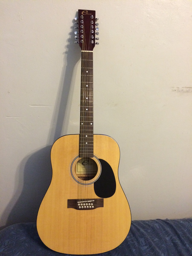

In [4]:
download_url(urls[0], 'images/guitarra.jpg')
im = Image.open('images/guitarra.jpg')
im.thumbnail((256,256))
im

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
instrumentos = 'guitarra','ukelele','bajo'
path = Path('gdrive/MyDrive/instrumentos')

if not path.exists():
  path.mkdir()
  for o in instrumentos:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} instrumento', max_images=60)
    cont = 0
    for i in results:
      try:
        download_url(i, str(dest) + "/" + str(cont) + ".jpg")
      except:
        print('Error')  
      cont += 1

Error


Error


Error


Error


Error


Error


In [6]:
fns = get_image_files(path)
fns

(#294) [Path('gdrive/MyDrive/instrumentos/guitarra/0.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/1.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/2.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/4.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/5.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/6.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/7.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/8.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/9.jpg'),Path('gdrive/MyDrive/instrumentos/guitarra/10.jpg')...]

Limpiamos las imagenes descargadas que estén corruptas

In [7]:
failed = verify_images(fns)
failed.map(Path.unlink);

Creamos el DataLoader

In [8]:
instrumentos = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

Entrenamos el modelo con las imágenes

In [9]:
instrumentos = instrumentos.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = instrumentos.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [10]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.802566,1.089995,0.421053,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.307824,0.929936,0.403509,00:14
1,1.196115,0.966553,0.350877,00:14
2,0.982566,0.845434,0.263158,00:13
3,0.874980,0.781700,0.245614,00:13


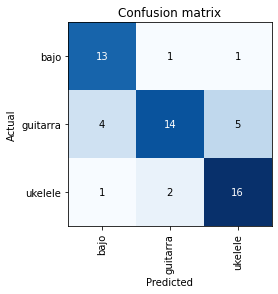

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

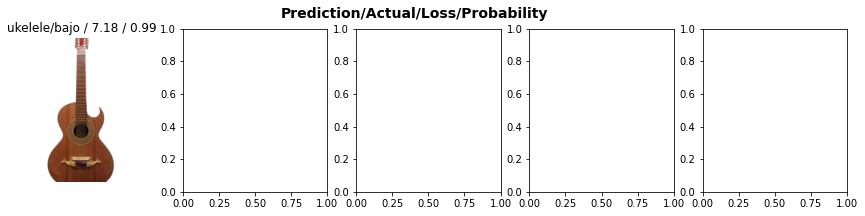

In [18]:
interp.plot_top_losses(5, nrows=1)

In [20]:
cleaner = ImageClassifierCleaner(learn)
cleaner

FileNotFoundError: ignored

In [15]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

Convertimos el modelo en una aplicación online

In [21]:
learn.export()

In [29]:
import PIL
path = Path()
learn_inf = load_learner(path/'export.pkl',cpu=True)
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

btn_run = widgets.Button(description='Clasificar')

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Predicción: {pred}; Probabilidad: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

VBox([widgets.Label('Seleciona tu instrumento'), 
      btn_upload, btn_run, out_pl, lbl_pred])